# Deciphering cell-cell communication in single-cell transcriptomics data


## Install the required libraries

In [8]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Tracing function "install.packages" in package "utils"



We will create an R function to performs system calls

In [9]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

Install required libraries

In [10]:
install.packages("R.utils")
#remotes::install_github('satijalab/seurat-wrappers@d28512f804d5fe05e6d68900ca9221020d52cf1d', upgrade=F)
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = T)

install.packages("harmony")
remotes::install_github('saezlab/liana', upgrade=F)

Skipping install of 'liana' from a github remote, the SHA1 (4c323df7) has not changed since last install.
  Use `force = TRUE` to force installation



## Introduction

LIANA provides different statistical methods to infer ligand-receptor interactions from single-cell transcriptomics data omics data using prior knowledge. In this notebook we showcase how to use liana in its' most basic form with our data of interest.

![LIANA](https://saezlab.github.io/liana/articles/ligrec_pipe.png)

In [11]:
install.packages("Seurat")

In [12]:
library(tidyverse)
library(magrittr)
library(liana)
library(Seurat)

Here we can show all the methods from other tools that LIANA implements. Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to the magnitude (strength) of interaction and the other reflecting how specificity of a given interaction to a pair cell identities.

In [13]:
show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

The different resources of ligand-receptor interactions can be found here. The consensus integrates all the other resources.

In [14]:
show_resources()

[1] "Default"          "Consensus"        "Baccin2019"       "CellCall"        
 [5] "CellChatDB"       "Cellinker"        "CellPhoneDB"      "CellTalkDB"      
 [9] "connectomeDB2020" "EMBRACE"          "Guide2Pharma"     "HPMR"            
[13] "ICELLNET"         "iTALK"            "Kirouac2010"      "LRdb"            
[17] "Ramilowski2015"   "OmniPath"         "MouseConsensus"

## Loading Data

Here we load our data of interest to study cell-cell communicaton.

In [15]:
download.file("https://www.dropbox.com/scl/fi/1ysew52kr8o2riahzubcw/BALF-COVID19-Liao_et_al-NatMed-2020.rds?rlkey=tg3tpn8la6oth25wvx3a22qt9&dl=1", "COVID.rds")

In [16]:
testdata <- readRDS('COVID.rds')

In [17]:
testdata %>% dplyr::glimpse()

Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	63103 obs. of  8 variables:
  .. ..$ sample    : Factor w/ 12 levels "C51","C52","C100",..: 3 3 3 3 3 3 3 3 3 3 ...
  .. ..$ sample_new: Factor w/ 12 levels "HC1","HC2","HC3",..: 3 3 3 3 3 3 3 3 3 3 ...
  .. ..$ group     : Factor w/ 3 levels "HC","M","S": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ disease   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ hasnCoV   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ cluster   : num [1:63103] 27 23 6 10 10 9 0 17 10 10 ...
  .. ..$ celltype  : Factor w/ 10 levels "B","Epithelial",..: 1 3 8 3 3 8 3 5 3 3 ...
  .. ..$ condition : Factor w/ 3 levels "Control","Moderate COVID-19",..: 1 1 1 1 1 1 1 1 1 1 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 1 level "AnnData": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "names")

In [18]:
testdata <- subset(x = testdata, subset = group == "S")

In [19]:
Idents(testdata) <- "celltype"

In [20]:
testdata <- Seurat::NormalizeData(testdata, verbose = FALSE)

In [21]:
testdata %>% dplyr::glimpse()


Formal class 'Seurat' [package "SeuratObject"] with 13 slots
  ..@ assays      :List of 1
  .. ..$ RNA:Formal class 'Assay' [package "SeuratObject"] with 8 slots
  ..@ meta.data   :'data.frame':	36619 obs. of  8 variables:
  .. ..$ sample    : Factor w/ 12 levels "C51","C52","C100",..: 11 11 11 11 11 11 11 11 11 11 ...
  .. ..$ sample_new: Factor w/ 12 levels "HC1","HC2","HC3",..: 11 11 11 11 11 11 11 11 11 11 ...
  .. ..$ group     : Factor w/ 3 levels "HC","M","S": 3 3 3 3 3 3 3 3 3 3 ...
  .. ..$ disease   : Factor w/ 2 levels "N","Y": 2 2 2 2 2 2 2 2 2 2 ...
  .. ..$ hasnCoV   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ cluster   : num [1:36619] 9 6 1 17 11 8 9 0 20 4 ...
  .. ..$ celltype  : Factor w/ 10 levels "B","Epithelial",..: 8 8 3 5 3 3 8 3 9 3 ...
  .. ..$ condition : Factor w/ 3 levels "Control","Moderate COVID-19",..: 3 3 3 3 3 3 3 3 3 3 ...
  ..@ active.assay: chr "RNA"
  ..@ active.ident: Factor w/ 10 levels "B","Epithelial",..: 8 8 3 5 3 3 8 3 9 3 .

## Running LIANA

We can run LIANA by using any of the methods that it implements. In this example, we use the implementation of [CellPhoneDB](https://www.nature.com/articles/s41596-020-0292-x). However, `liana_wrap` calls a number of methods and each method is run with the provided resource(s). If no method is specified, it runs all methods implemented in LIANA. Similarly, the `consensus` is the default resource.

In [22]:
cpdb_result <- liana_wrap(testdata,
                          method = 'cellphonedb',
                          resource = c('CellPhoneDB'),
                          permutation.params = list(nperms=100,
                                                    parallelize=FALSE,
                                                    workers=4),
                          expr_prop=0.05)

Expression from the `RNA` assay will be used

Running LIANA with `celltype` as labels!

Warning message in exec(output, ...):
“6808 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
LIANA: LR summary stats calculated!

Now Running: Cellphonedb

Warning message:
“`progress_estimated()` was deprecated in dplyr 1.0.0.
ℹ The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>.”


In [23]:
dplyr::glimpse(cpdb_result)

Rows: 7,835
Columns: 12
$ source           <chr> "T", "T", "T", "T", "T", "T", "T", "T", "T", "T", "T"…
$ target           <chr> "T", "T", "T", "T", "T", "T", "T", "T", "T", "T", "T"…
$ ligand.complex   <chr> "CXCL16", "CCL5", "CCL8", "CCL4", "LTA", "CXCL10", "C…
$ ligand           <chr> "CXCL16", "CCL5", "CCL8", "CCL4", "LTA", "CXCL10", "C…
$ receptor.complex <chr> "CXCR6", "CCR5", "CCR5", "CCR5", "TNFRSF1A", "CXCR3",…
$ receptor         <chr> "CXCR6", "CCR5", "CCR5", "CCR5", "TNFRSF1A", "CXCR3",…
$ receptor.prop    <dbl> 0.23829201, 0.24173554, 0.24173554, 0.24173554, 0.164…
$ ligand.prop      <dbl> 0.08930211, 0.67791552, 0.22933884, 0.52249770, 0.135…
$ ligand.expr      <dbl> 0.10750502, 2.16021901, 0.41310354, 1.41548671, 0.175…
$ receptor.expr    <dbl> 0.38005758, 0.28682271, 0.28682271, 0.28682271, 0.174…
$ lr.mean          <dbl> 0.2437813, 1.2235209, 0.3499631, 0.8511547, 0.1746789…
$ pvalue           <dbl> 1.00, 0.00, 1.00, 1.00, 1.00, 1.00, 0.00, 0.00, 1.00,…


We can also select multiple methods, an run all of them. Here we use CellPhoneDB, NATMI, SingleCellSignalR (sca), and the logFC approach.

In [24]:
complex_test <- liana_wrap(testdata,
                           method = c('cellphonedb', 'natmi', 'sca', 'logfc'),
                           resource = c('CellPhoneDB'))

Expression from the `RNA` assay will be used

Running LIANA with `celltype` as labels!

Warning message in exec(output, ...):
“6808 genes and/or 0 cells were removed as they had no counts!”
LIANA: LR summary stats calculated!

Now Running: Cellphonedb

Now Running: Natmi

Now Running: Sca

Now Running: Logfc



In [25]:
dplyr::glimpse(complex_test)

List of 4
 $ cellphonedb: tibble [4,804 × 12] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:4804] "T" "T" "T" "T" ...
  .. ..- attr(*, "levels")= chr [1:10] "B" "Epithelial" "Macrophages" "Mast" ...
  ..$ target          : chr [1:4804] "T" "T" "T" "T" ...
  .. ..- attr(*, "levels")= chr [1:10] "B" "Epithelial" "Macrophages" "Mast" ...
  ..$ ligand.complex  : chr [1:4804] "CCL5" "CCL8" "CCL4" "LTA" ...
  ..$ ligand          : chr [1:4804] "CCL5" "CCL8" "CCL4" "LTA" ...
  ..$ receptor.complex: chr [1:4804] "CCR5" "CCR5" "CCR5" "TNFRSF1A" ...
  ..$ receptor        : chr [1:4804] "CCR5" "CCR5" "CCR5" "TNFRSF1A" ...
  ..$ receptor.prop   : num [1:4804] 0.242 0.242 0.242 0.164 0.313 ...
  ..$ ligand.prop     : num [1:4804] 0.678 0.229 0.522 0.136 0.301 ...
  ..$ ligand.expr     : num [1:4804] 2.16 0.413 1.415 0.175 0.596 ...
  ..$ receptor.expr   : num [1:4804] 0.287 0.287 0.287 0.174 0.411 ...
  ..$ lr.mean         : num [1:4804] 1.224 0.35 0.851 0.175 0.504 ...
  ..$ pvalue   

One of the key features of LIANA is that it can compute a consensus ranking of the prediction of all methods employed to analyze cell-cell communication. By using the function `liana_aggregate()` we can use all the results from every method used in the previous step.

In [26]:
liana_consensus <- complex_test %>% liana_aggregate()

Now aggregating cellphonedb

Now aggregating natmi

Now aggregating sca

Now aggregating logfc

Aggregating Ranks



In [27]:
dplyr::glimpse(liana_consensus)

Rows: 4,804
Columns: 14
$ source                 <chr> "Epithelial", "Epithelial", "Neutrophil", "Epit…
$ target                 <chr> "Epithelial", "Epithelial", "pDC", "Macrophages…
$ ligand.complex         <chr> "SCGB3A1", "CEACAM6", "NAMPT", "SCGB3A1", "LCK"…
$ receptor.complex       <chr> "NOTCH3", "CEACAM5", "P2RY6", "MARCO", "CD8A_CD…
$ aggregate_rank         <dbl> 5.085776e-05, 5.085776e-05, 2.763643e-04, 3.352…
$ mean_rank              <dbl> 716.00, 322.50, 257.25, 276.75, 399.50, 415.50,…
$ cellphonedb.pvalue     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ cellphonedb.rank       <dbl> 808, 808, 808, 808, 808, 808, 808, 808, 808, 80…
$ natmi.edge_specificity <dbl> 0.67226981, 0.94778034, 0.18253727, 0.40750492,…
$ natmi.rank             <dbl> 7, 1, 80, 18, 15, 20, 149, 21, 165, 849, 36, 20…
$ sca.LRscore            <dbl> 0.8453234, 0.9184651, 0.9528099, 0.9321491, 0.9…
$ sca.rank               <dbl> 2047, 474, 125, 280, 756, 829, 65, 1180, 71, 34…
$ logfc.logfc_co

## Visualization and Interpretation

Dotplots can be generated to easily interpret important ligand-receptor pairs used by sender-receiver cell pairs.

Here, we preprocess the results of CellPhoneDB, then plot them. A filter to use only significant cases is applied (P-value < 0.05).

In [28]:
cpdb_int <- cpdb_result %>%
  # only keep interactions with p-val <= 0.05
  filter(pvalue <= 0.05) %>% # this reflects interactions `specificity`
  # then rank according to `magnitude` (lr_mean in this case)
  rank_method(method_name = "cellphonedb",
              mode = "magnitude") %>%
  # keep top 20 interactions (regardless of cell type)
  distinct_at(c("ligand.complex", "receptor.complex")) %>%
  head(20)

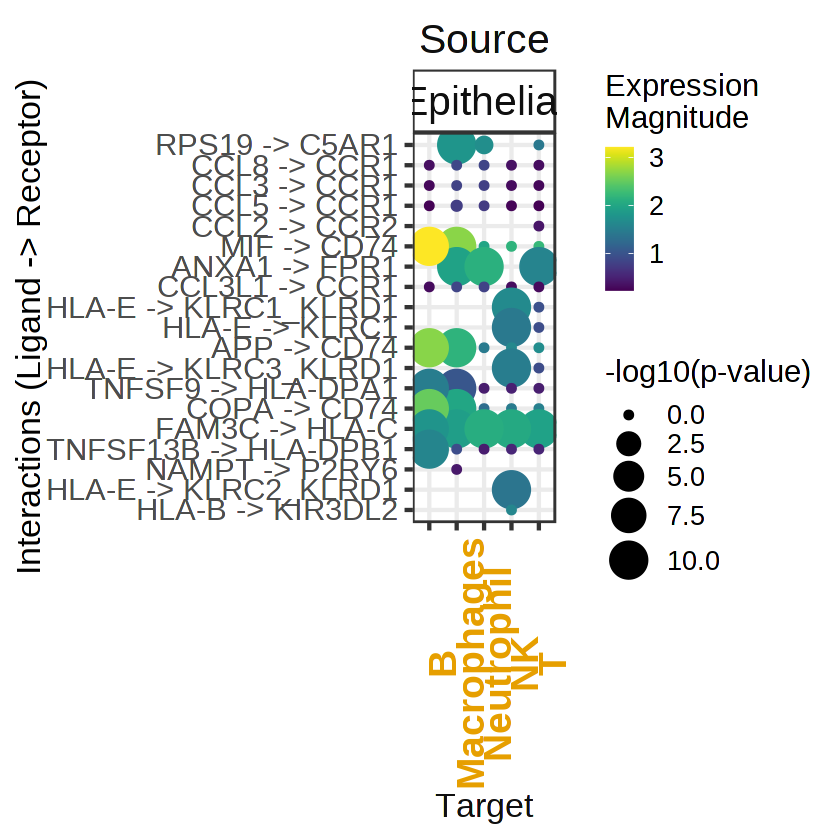

In [30]:
#options(repr.plot.height = 12, repr.plot.width = 9)
# Plot toy results
scPlot <- cpdb_result %>%
          # keep only the interactions of interest
          inner_join(cpdb_int,
                    by = c("ligand.complex", "receptor.complex")) %>%
          # invert size (low p-value/high specificity = larger dot size)
          # + add a small value to avoid Infinity for 0s
          mutate(pvalue = -log10(pvalue + 1e-10)) %>%
          liana_dotplot(source_groups = c("Epithelial"),
                        target_groups = c("Macrophages", "NK", "B", "T", "Neutrophil"),
                        specificity = "pvalue",
                        magnitude = "lr.mean",
                        show_complex = TRUE,
                        size.label = "-log10(p-value)") + theme(axis.text.x = element_text(angle = 90))
scPlot
ggsave("01-liana_dotplot.png", plot = scPlot, bg = "white", dpi = 600, width = 16, height = 9)

Similarly, we can explore the consensus results.

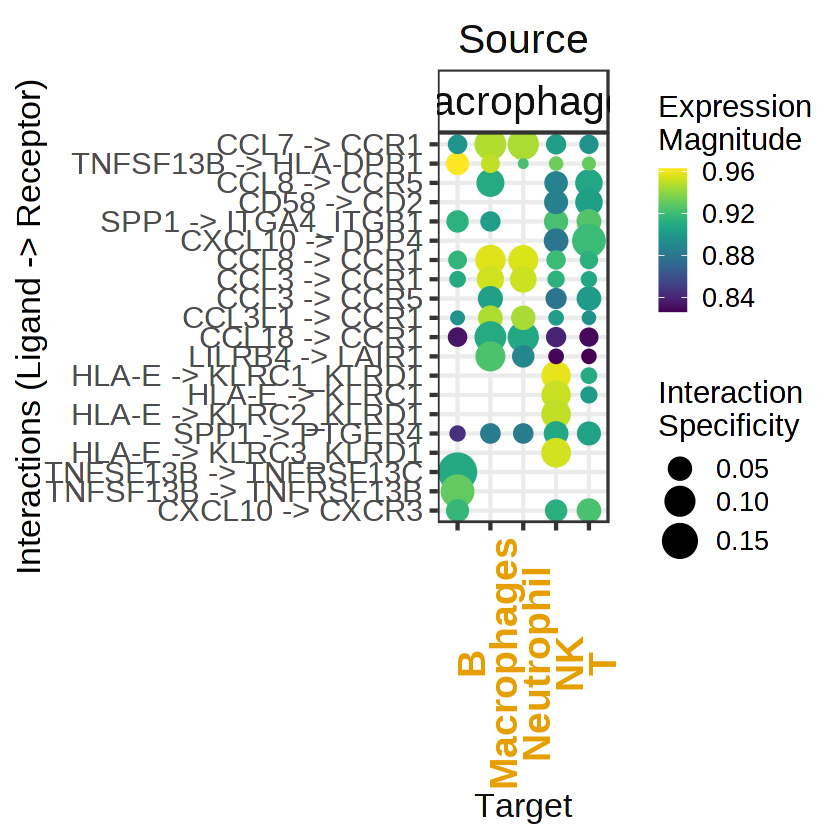

In [32]:
#options(repr.plot.height = 12, repr.plot.width = 9)
scPlot <- liana_consensus %>%
          liana_dotplot(source_groups = c("Macrophages"),
                        target_groups = c("Macrophages", "NK", "B", "T", "Neutrophil"),
                        ntop = 20) + theme(axis.text.x = element_text(angle = 90))
scPlot
ggsave("02-liana_dotplot.png", plot = scPlot, bg = "white", dpi = 600, width = 16, height = 9)

Overall potential of cells to communicate can be computed. Here, we can count the number of significant/important interactions. Then, they can be visualized through a heatmap.

Similarly, we can compare the CellPhoneDB vs consensus results.

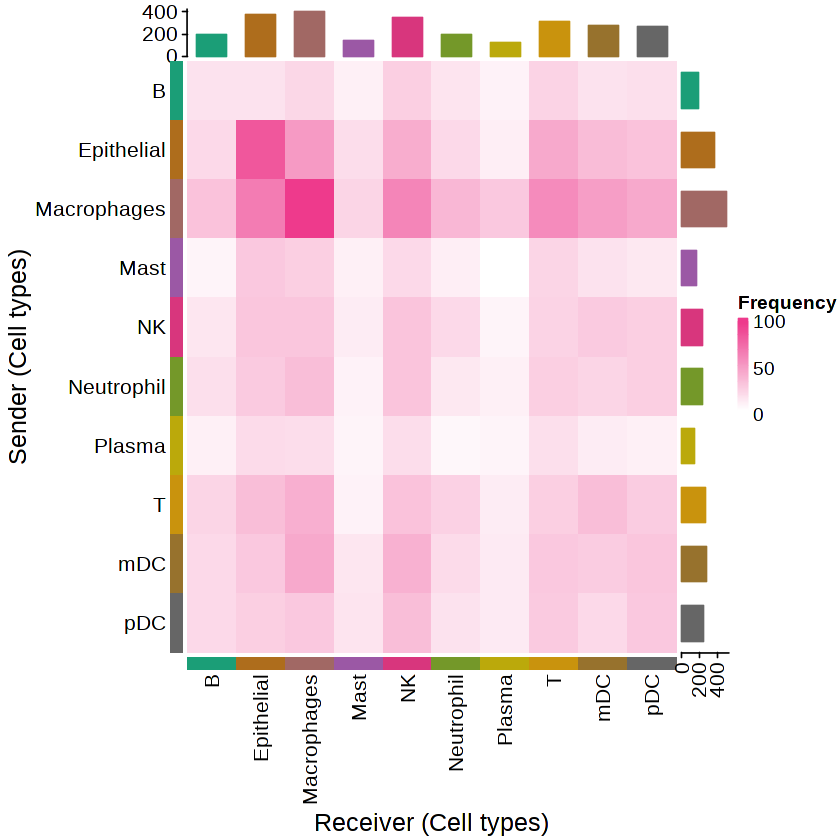

In [33]:
liana_trunc <- cpdb_result %>%
   # only keep interactions concordant between methods
  filter(pvalue <= 0.05) # note that these pvals are already corrected
#png("03-heat_freq.png", bg = "white")
heat_freq(liana_trunc)
#dev.off()

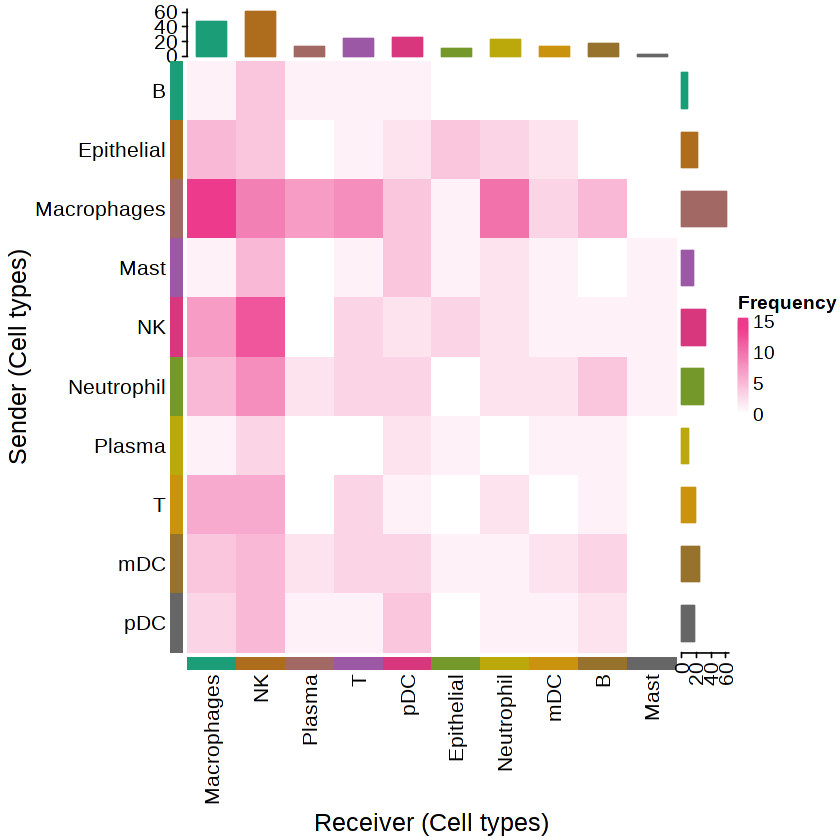

In [34]:
liana_trunc <- liana_consensus %>%
   # only keep interactions concordant between methods
  filter(aggregate_rank <= 0.01) # note that these pvals are already corrected
#png("04-heat_freq.png", bg = "white")
heat_freq(liana_trunc)
#dev.off()

## Extra Questions:

- How different are the results between two methods of your choice?

- Why can this happen?


In [35]:
ls("package:liana")

[1] "assign_lr_weights"            "calculate_gini"              
 [3] "call_cellchat"                "call_connectome"             
 [5] "call_italk"                   "call_natmi"                  
 [7] "call_sca"                     "call_squidpy"                
 [9] "cellchat_formatDB"            "chord_freq"                  
[11] "compile_ligrec"               "conn_formatDB"               
[13] "decomplexify"                 "decompose_tensor"            
[15] "filter_nonabundant_celltypes" "FormatConnectome"            
[17] "FormatiTALK"                  "FormatSCA"                   
[19] "generate_homologs"            "generate_lr_geneset"         
[21] "generate_omni"                "generate_orthologs"          
[23] "get_abundance_summary"        "get_c2c_factors"             
[25] "get_connectome"               "get_curated_omni"            
[27] "get_logfc"                    "get_lr_resources"            
[29] "get_natmi"                    "get_sca"                     
[31] "heat_freq"                    "italk_formatDB"              
[33] "join_means"                   "liana_aggregate"             
[35] "liana_bysample"               "liana_call"                  
[37] "liana_defaults"               "liana_dotplot"               
[39] "liana_heatmap"                "liana_pipe"                  
[41] "liana_prep"                   "liana_tensor_c2c"            
[43] "liana_wrap"                   "mean0"                       
[45] "minmax"                       "plot_abundance_summary"      
[47] "plot_c2c_cells"               "plot_c2c_overview"           
[49] "plot_context_boxplot"         "plot_context_heat"           
[51] "plot_lr_heatmap"              "rank_aggregate"              
[53] "rank_method"                  "recomplexify"                
[55] "sca_formatDB"                 "select_resource"             
[57] "show_homologene"              "show_methods"                
[59] "show_resources"